In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
!unzip -qq "/content/gdrive/MyDrive/피카추,라이추,개추.zip"

In [3]:
import os
import numpy as np
import torch
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch import nn, optim
from matplotlib import pyplot as plt
import seaborn as sns

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


https://www.kaggle.com/code/kimyoung2/pokemon-dcgan/edit

In [5]:
path = "/content/pokemon_jpg"
os.path.exists(path)

True

In [6]:
norm=((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
batch_size = 64
image_size = 64

In [7]:
transf = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(*norm,inplace=True),
])

In [8]:
from torchvision import datasets

dataset = datasets.ImageFolder(root=path,transform=transf)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [9]:
def unnorm(images, means, stds):
    means = torch.tensor(means).reshape(1,3,1,1)
    stds = torch.tensor(stds).reshape(1,3,1,1)
    return images*stds+means

In [10]:
def show_batch(data_loader):
    for images, labels in data_loader:
        fig, ax = plt.subplots(figsize=(15,15))
        ax.set_xticks([]); ax.set_yticks([])
        unnorm_images = unnorm(images, *norm)
        ax.imshow(make_grid(unnorm_images[:batch_size], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

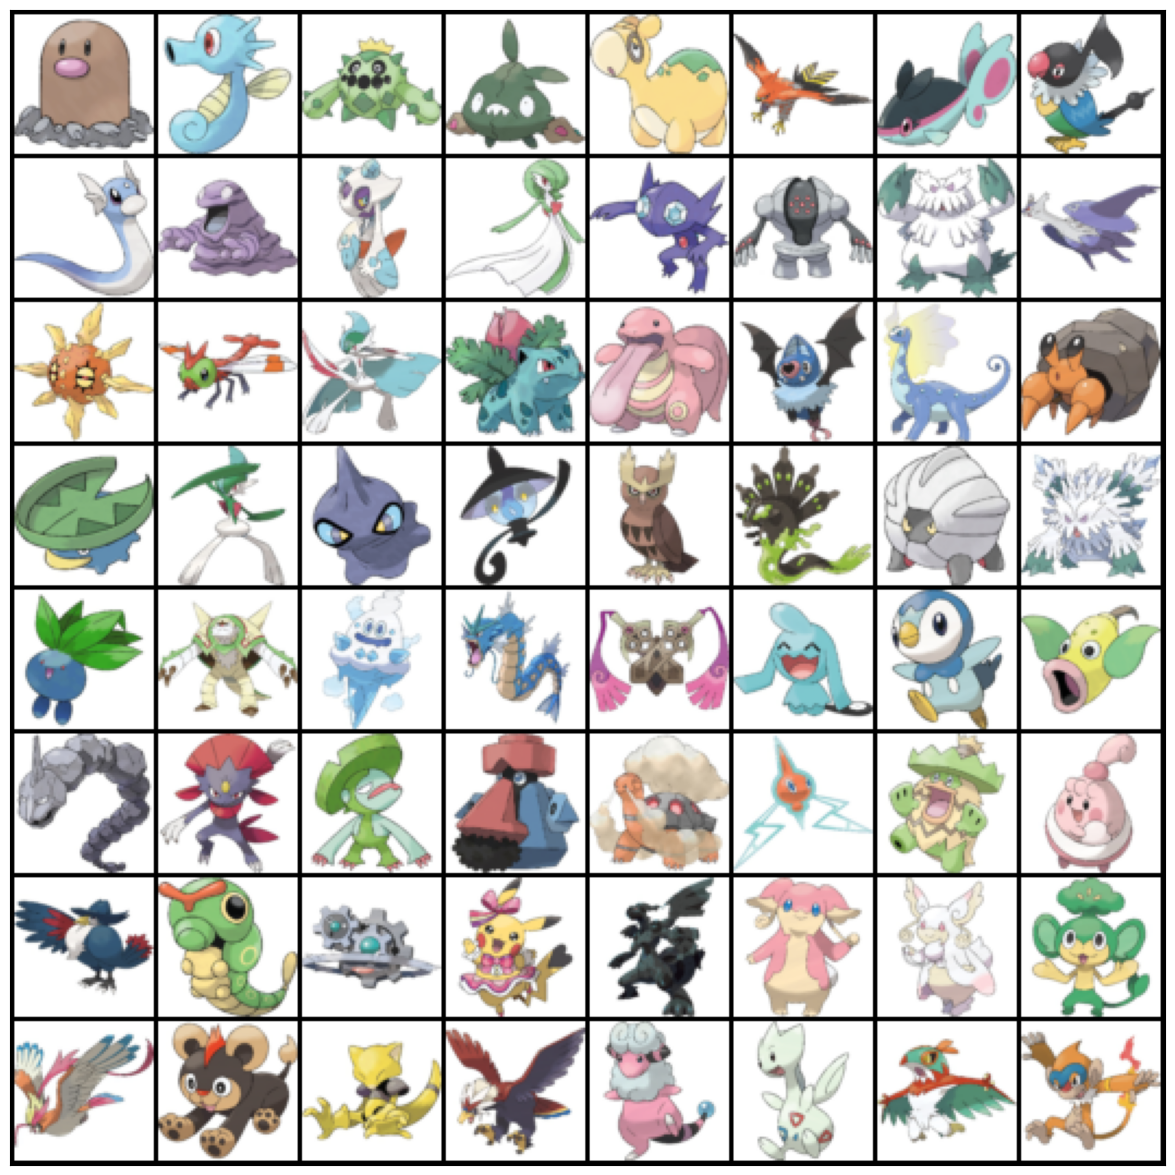

In [11]:
show_batch(dataloader)

In [12]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [13]:
# class Generator(nn.Module):
#     def __init__(self):
#       super(Generator,self).__init__()
#       self.main = nn.Sequential(
#           nn.ConvTranspose2d(100,64*8,1,0,bias=False),
#           nn.BatchNorm2d(64*8),
#           nn.ReLU(True),
#           nn.ConvTranspose2d(64*8, 64*4, 4,2,1,bias=False),
#           nn.BatchNorm2d(64*4),
#           nn.ReLU(True),
#           nn.ConvTranspose2d(64*4,64*2,4,2,1,bias=False),
#           nn.BatchNorm2d(64*2),
#           nn.ReLU(True),
#           nn.ConvTranspose2d(64*2,64,4,2,1,bias=False),
#           nn.BatchNorm2d(64),
#           nn.ReLU(True),
#           nn.ConvTranspose2d(64,3,4,2,1,bias=False),
#           nn.Tanh()
#       )
#     def forward(self,input):
#       return self.main(input)

# modelG = Generator()
# modelG.to(device)
# modelG.apply(weights_init)


In [14]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 64 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

modelG = Generator()
modelG.to(device)
modelG.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [15]:

class Discriminator(nn.Module):
    def __init__(self):
      super(Discriminator, self).__init__()
      self.main = nn.Sequential(
          nn.Conv2d(3,64,4,2,1,bias=False),
          nn.LeakyReLU(0.2,inplace=True),
          nn.Conv2d(64,64*2,4,2,1, bias=False),
          nn.BatchNorm2d(64*2),
          nn.LeakyReLU(0.2,inplace=True),
          nn.Conv2d(64*2,64*4,4,2,1,bias=False),
          nn.BatchNorm2d(64*4),
          nn.Conv2d(64*4,64*8,4,2,1,bias=False),
          nn.BatchNorm2d(64*8),
          nn.LeakyReLU(0.2,inplace=True),
          nn.Conv2d(64*8,1,4,1,0,bias=False),
          nn.Sigmoid()
      )
    def forward(self, input):
      return self.main(input)

modelD = Discriminator()
modelD.to(device)
modelD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (11): Sigmoid()
  )
)

In [16]:
criterion = nn.BCELoss()
fixed_noise = torch.randn(64,100,1,1,device=device)
real_label=1
fake_label = 0
optimizerD = optim.Adam(modelD.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizerG = optim.Adam(modelG.parameters(), lr=0.0001, betas=(0.5, 0.999))


In [17]:
import torchvision.utils as vutils

img_list = []
G_losses, D_losses = [], []

total = 0

for epoch in range(500):
  g_loss = 0.0
  d_loss = 0.0
  D_x = 0.0
  D_G_z1 = 0.0
  D_G_z2 = 0.0
  #각 요소에 인덱스를 붙이기 위해서 0을 사용.
  for i, data in enumerate(dataloader,0):
      ##########################판별자 학습####################
      modelD.zero_grad()
      # PyTorch의 DataLoader를 사용하여 데이터셋을
      #불러올 때, 각 배치(batch)를 GPU로 이동시키기 위한 코드
      real_cpu = data[0].to(device)
      #real_cpu.size(0)은 현재 배치의 첫 번째 차원의 크기
      b_size = real_cpu.size(0)
      #torch.full() 함수는 주어진 크기의 텐서를 생성하고,
      #모든 요소를 지정한 값으로 채웁니다.
      #b_size가 배치사이즈니까 그 사이즈 만큼, real_label=1을 텐서로 채워라는거네?
      label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
      #판별자 모델에 배치만큼 데이터를 집어넣음
      output = modelD(real_cpu).view(-1)
      #이 label(진짜 값)과 output(결과값)으로 손실함수 구하기
      errD_real = criterion(output, label)
      errD_real.backward()
      #output.mean()은 모델의 정확도(accuracy)를 의미함.
      #item은 mean값을 스칼라값으로 변경해서 교체하는 역활

      ##########################생성자 학습####################
      D_x += output.mean().item()
      noise = torch.randn(b_size, 100,1,1,device=device)
      fake = modelG(noise)
      #이미 label에 true label이 있기때문에, fake만 추가
      label.fill_(fake_label)
      #그래디언트 계산을 방지하기 위해 fake.detachs()를 적용
      #안쓰면 학습이 불안정해짐
      #손실함수 계산을 위해 1차원 벡터로 만들어야 하는데, 따라서 view(-1)을 사용
      output = modelD(fake.detach()).view(-1)
      errD_fake = criterion(output,label)
      errD_fake.backward()
      D_G_z1 += output.mean().item()
      errD = errD_real + errD_fake
      optimizerD.step()

     #########################fake_image를 판별자에######################
      #기울기 초기화
      modelG.zero_grad()
      label.fill_(real_label)
      output = modelD(fake).view(-1)
      errG = criterion(output, label)
      errG.backward()
      D_G_z2 += output.mean().item()
      optimizerG.step()

      #생성자, 판별자 각각에 손실값을 갱신
      g_loss += errG.item()
      d_loss += errD.item()
      #각 배치를 더하는거
      total += b_size
  #D_x는 실제 데이터셋으로 판별한 평균 정확도,
  # D_G_z1은 가짜 데이터셋으로 판별한 평균 정확도, 
  #D_G_z2는 생성자가 만든 가짜 데이터셋으로 판별한 평균 정확도

  #######손실함수 갱신######
  avg_g_loss = g_loss/total
  G_losses.append(avg_g_loss)
  avg_d_loss = d_loss/total
  D_losses.append(avg_d_loss)


  ########평균 정확도#############
  avg_D_x = D_x / len(dataloader)
  avg_D_G_z1 = D_G_z1 / len(dataloader)
  avg_D_G_z2 = D_G_z2 / len(dataloader)
  print('Epoch: {} \tDiscriminator Loss: {:.6f} \tGenerator Loss: {:.6f} \tD(x): {:.6f} \tD(G(z)): {:.6f} / {:.6f}'.format(
        epoch + 1,
        avg_d_loss,
        avg_g_loss,
        avg_D_x,
        avg_D_G_z1,
        avg_D_G_z2
    ))
  #######모델 추론##########
  with torch.no_grad():
      fake = modelG(fixed_noise).detach().cpu()
  img_list.append(vutils.make_grid(unnorm(fake, *norm), padding=2, normalize=True))


print('finish')      

Epoch: 1 	Discriminator Loss: 0.008342 	Generator Loss: 0.068420 	D(x): 0.901601 	D(G(z)): 0.269755 / 0.027633
Epoch: 2 	Discriminator Loss: 0.001583 	Generator Loss: 0.049769 	D(x): 0.953056 	D(G(z)): 0.123910 / 0.003262
Epoch: 3 	Discriminator Loss: 0.000769 	Generator Loss: 0.041636 	D(x): 0.956459 	D(G(z)): 0.085112 / 0.000674
Epoch: 4 	Discriminator Loss: 0.001005 	Generator Loss: 0.042325 	D(x): 0.940689 	D(G(z)): 0.129035 / 0.000479
Epoch: 5 	Discriminator Loss: 0.002293 	Generator Loss: 0.041839 	D(x): 0.847715 	D(G(z)): 0.165475 / 0.000746
Epoch: 6 	Discriminator Loss: 0.001403 	Generator Loss: 0.034654 	D(x): 0.895802 	D(G(z)): 0.173515 / 0.001272
Epoch: 7 	Discriminator Loss: 0.000405 	Generator Loss: 0.020937 	D(x): 0.935329 	D(G(z)): 0.081056 / 0.000380
Epoch: 8 	Discriminator Loss: 0.000516 	Generator Loss: 0.016565 	D(x): 0.893358 	D(G(z)): 0.097518 / 0.001305
Epoch: 9 	Discriminator Loss: 0.000816 	Generator Loss: 0.015676 	D(x): 0.841940 	D(G(z)): 0.130357 / 0.010341
E

In [18]:
torch.save(modelG.state_dict(), 'G.pth')
torch.save(modelD.state_dict(), 'D.pth')

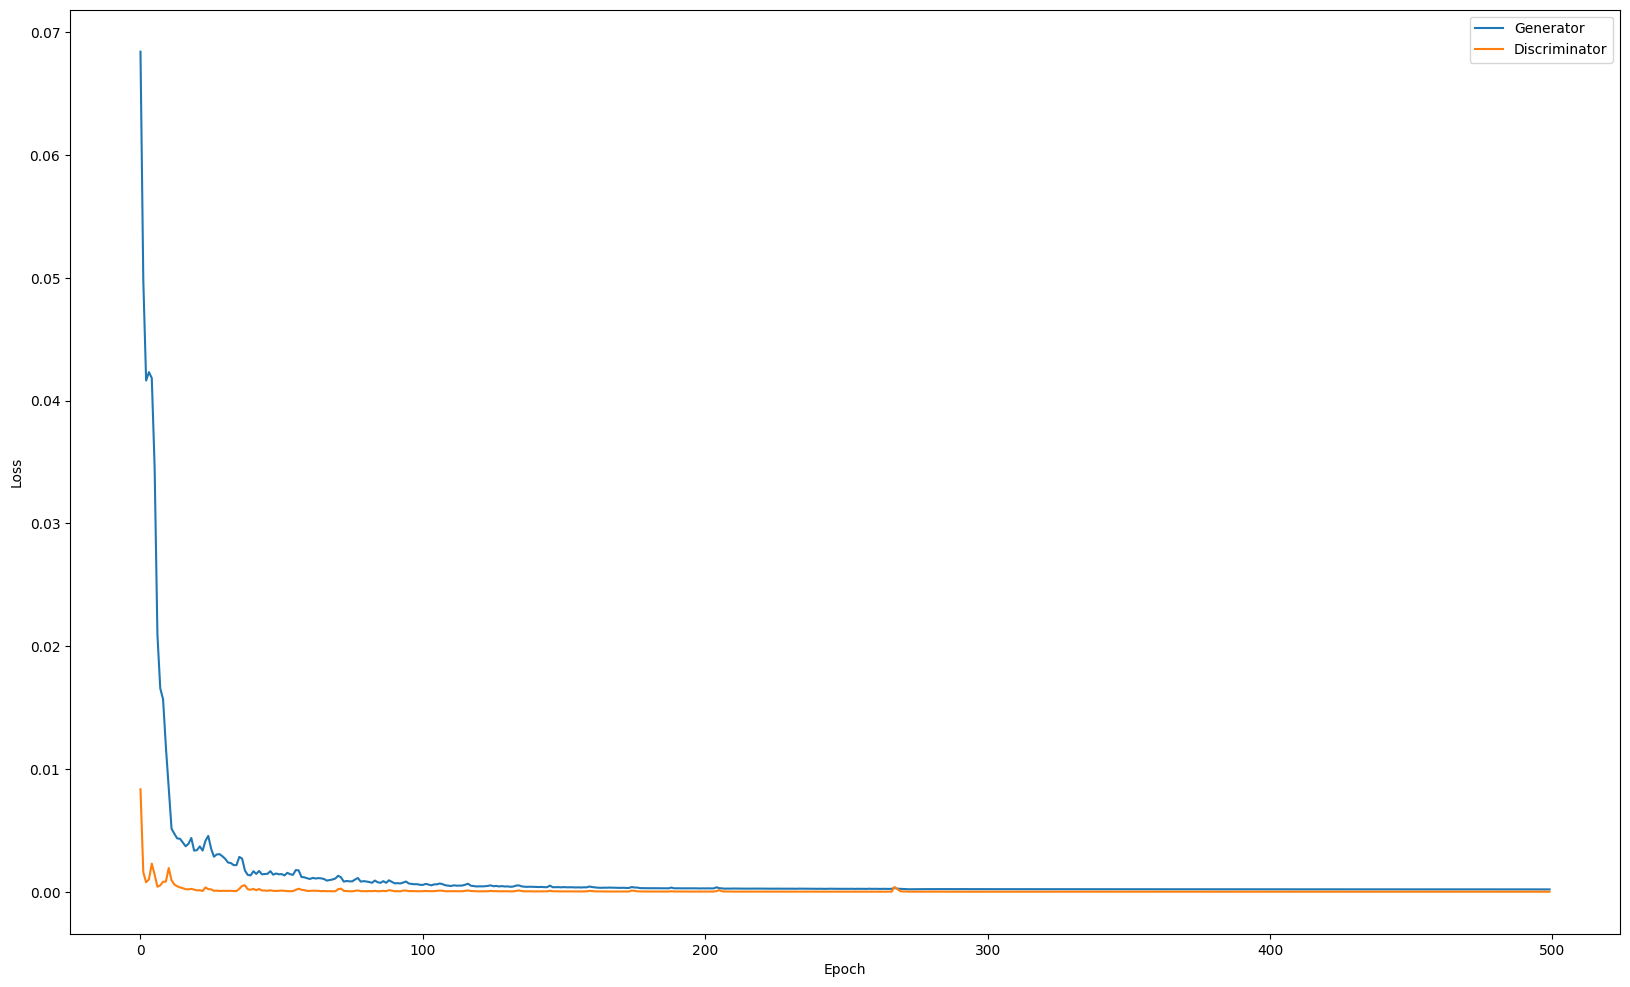

In [19]:
plt.figure(figsize=(20,12))
plt.plot(G_losses,label="Generator")
plt.plot(D_losses,label="Discriminator")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [21]:
# import matplotlib.animation as animation
# from IPython.display import HTML

# fig = plt.figure(figsize=(8, 8))
# plt.axis("off")
# ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list[::15]]
# ani = animation.ArtistAnimation(fig, ims, interval=250, repeat_delay=250, blit=True)

# HTML(ani.to_jshtml())